## Setup secrets

In [1]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
WANDB_TOKEN = user_secrets.get_secret("WANDB_TOKEN")

## Load Dataset

In [2]:
# Downgrade fsspec and rich to match other packages' requirements
%pip install --quiet fsspec==2024.10.0 rich<14
print("✅ fsspec and rich downgraded.")

%pip install --quiet datasets pandas transformers huggingface_hub ipywidgets
print("✅ Initial libraries installed.")

# Install compatible CUDA libraries for torch 2.5.1+cu124
%pip install --quiet torch==2.5.1+cu124 torchvision==0.16.1+cu124 torchaudio==2.5.1+cu124 --extra-index-url https://download.pytorch.org/whl/cu124
print("✅ CUDA libraries installed.")


from datasets import load_dataset
# import pandas as pd

dataset = load_dataset("mteb/tweet_sentiment_extraction")
print("✅ Dataset loaded.")

/bin/bash: line 1: 14: No such file or directory
Note: you may need to restart the kernel to use updated packages.
✅ fsspec and rich downgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuff

README.md:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27481 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3534 [00:00<?, ? examples/s]

✅ Dataset loaded.


## HuggingFace Setup

In [3]:
import huggingface_hub

try:
    # login(token=HF_TOKEN)
    huggingface_hub.login(token=HF_TOKEN)
    print("✅ Logged in to Hugging Face Hub")
except Exception as e:
    print(f"❌ Error during login: {e}")
    print("✅ Please ensure you have a valid Hugging Face token in your .env file.")
    exit(1)

✅ Logged in to Hugging Face Hub


# Import models

In [4]:
import torch
from transformers import AutoModelForSequenceClassification, AutoModelForCausalLM, AutoTokenizer

BASE_MODEL = "Qwen/Qwen2.5-0.5B"
FT_MODEL = "rtweera/Qwen2.5-0.5B_2025-04-18_11-44-30"

base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)    
base_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True, padding_side='left')

ft_model = AutoModelForSequenceClassification.from_pretrained(FT_MODEL, num_labels=3)
ft_tokenizer = AutoTokenizer.from_pretrained(FT_MODEL, trust_remote_code=True)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
base_model.to(device)
ft_model.to(device)

# Set to eval mode
base_model.eval()
ft_model.eval()

# Set the pad token ID
base_model.config.pad_token_id = base_tokenizer.pad_token_id # Set the pad token ID in the model's config
print(f"✅ Model pad_token_id set.")

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

2025-04-21 02:27:26.587154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745202446.829268      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745202446.897971      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.26k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

✅ Model pad_token_id set.


# Setup Metrics

In [ ]:
# %debug
from IPython.core.debugger import set_trace
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import gc
import torch
import numpy

def get_zero_shot_prompt(test_dataset):
    texts = test_dataset['text']
    labels = test_dataset['label_text']
    prompts = []
    for text in texts:
        prompt = f"Please classify the following tweet as `positive`, `negative`, or `neutral`: {text}"
        prompts.append(prompt)
    return prompts, labels

def get_one_shot_prompt(test_dataset):
    texts = test_dataset['text']
    labels = test_dataset['label_text']
    prompts = []
    for text in texts:
        prompt = f"Please classify the sentiment of the following tweet as `positive`, `negative`, or `neutral`. Here's an example:\n\nTweet: This is the best day ever!\nSentiment: positive\n\nTweet: {text}\nSentiment:"
        prompts.append(prompt)
    return prompts, labels

def get_few_shot_prompt(test_dataset):
    texts = test_dataset['text']
    labels = test_dataset['label_text']
    prompts = []
    for text in texts:
        prompt = f"Please classify the sentiment of the following tweets as `positive`, `negative`, or `neutral`. Here are a few examples:\n\nTweet: I am so happy right now!\nSentiment: positive\n\nTweet: This is absolutely terrible.\nSentiment: negative\n\nTweet: The weather is cloudy today.\nSentiment: neutral\n\nTweet: I'm feeling quite disappointed.\nSentiment: negative\n\nTweet: {text}\nSentiment:"
        prompts.append(prompt)
    return prompts, labels

def get_prediction_from_response(response):
    if "positive" in response and "negative" not in response and "neutral" not in response:
        return "positive"
    elif "negative" in response and "positive" not in response and "neutral" not in response:
        return "negative"
    elif "neutral" in response and "positive" not in response and "negative" not in response:
        return "neutral"
    else:
        return "unknown"

def calc_metrics(all_true_labels, all_predictions, eval_type):
    print(f"✅ Completed all batches. Now calculating metrics...")

    accuracy = accuracy_score(all_true_labels, all_predictions)
    print(f"📝 Accuracy: {accuracy:.2f}")
    f1 = f1_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
    print(f"📝 F1 score calculated: {f1:.2f}")
    print(f"📝 Classification report:\n{classification_report(all_true_labels, all_predictions, zero_division=0)}")

    print("📝 Confusion matrix:")
    cm = pd.crosstab(
        pd.Series(all_true_labels, name='Actual'),
        pd.Series(all_predictions, name='Predicted'),
        dropna=False
    )
    cm = cm.reindex(index=['negative', 'neutral', 'positive'], columns=['negative', 'neutral', 'positive', 'unknown'], fill_value=0)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {eval_type} Evaluation')
    plt.tight_layout()
    plt.show()

    print("📝 Prediction Counts")

    # Series of predictions and true labels
    pred_series = pd.Series(all_predictions)
    true_series = pd.Series(all_true_labels)

    # Normalize labels
    label_order = ['negative', 'neutral', 'positive', 'unknown']
    pred_series_clean = pred_series.str.strip().str.lower()
    true_series_clean = true_series.str.strip().str.lower()

    # Count occurrences
    pred_counts = pred_series_clean.value_counts().reindex(label_order, fill_value=0)
    true_counts = true_series_clean.value_counts().reindex(label_order, fill_value=0)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Predicted labels bar plot
    pred_counts.plot(kind='bar', ax=ax, width=0.4, position=0, color='mediumseagreen', label='Predicted Counts')

    # Overlay true labels as a line
    ax.plot(range(len(true_counts)), true_counts.values, color='orange', marker='o', label='True Label Counts', linewidth=2)

    # Label stuff
    ax.set_xticks(range(len(label_order)))
    ax.set_xticklabels(label_order)
    plt.title("Predicted vs True Label Distribution")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

def evaluate_base_model(tokenizer, model, test_dataset, eval_type, batch_size=500):
    if eval_type == 'zero-shot':
        prompts, labels = get_zero_shot_prompt(test_dataset)
    elif eval_type == 'one-shot':
        prompts, labels = get_one_shot_prompt(test_dataset)
    elif eval_type == 'few-shot':
        prompts, labels = get_few_shot_prompt(test_dataset)
    else:
        raise ValueError(f"Invalid eval_type: {eval_type}")
    print(f"✅ {eval_type} prompts generated.")

    all_predictions = []
    all_true_labels = []

    # Process in batches
    for start in tqdm(range(0, len(prompts), batch_size), desc="🔄 Processing batches"):
        end = start + batch_size
        batch_prompts = prompts[start:end]
        batch_labels = labels[start:end]

        # inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True).to(device)
        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                do_sample=False,
                max_new_tokens=10,
                pad_token_id=tokenizer.eos_token_id
            )

        # Decode
        responses = []
        for i in range(len(outputs)):
            input_len = inputs["input_ids"][i].shape[0]
            response = tokenizer.decode(outputs[i][input_len:], skip_special_tokens=True)
            responses.append(response)

        cleaned_responses = list(map(lambda x: x.strip().lower(), responses))
        predictions = list(map(get_prediction_from_response, cleaned_responses))

        all_predictions.extend(predictions)
        all_true_labels.extend(batch_labels)
    print(f"✅ Completed all batches. Now calculating metrics...")
    calc_metrics(all_true_labels, all_predictions, eval_type)

    # Cleanup
    for v in inputs.values():
        del v
    del inputs
    del outputs
    torch.cuda.empty_cache()
    gc.collect()
    print("🧹 Cleared GPU cache and collected garbage.")

def evaluate_ft_model(tokenizer, model, test_dataset, eval_type=None, batch_size=5):
    if eval_type == 'zero-shot':
        prompts, labels = get_zero_shot_prompt(test_dataset)
    elif eval_type == 'one-shot':
        prompts, labels = get_one_shot_prompt(test_dataset)
    elif eval_type == 'few-shot':
        prompts, labels = get_few_shot_prompt(test_dataset)
    elif eval_type is None:
        prompts = test_dataset['text']
        labels = test_dataset['label_text']
    else:
        raise ValueError(f"Invalid eval_type: {eval_type}")
    print(f"✅ {eval_type} prompts generated.")

    all_predictions = []
    all_true_labels = []

    for start in tqdm(range(0, len(test_dataset), batch_size), desc="🔄 Processing batches"):
        end = start + batch_size
        batch_prompts = prompts[start:end]
        batch_labels = labels[start:end]

        # batch_prompts = test_dataset['text'][start:end]
        # batch_labels = test_dataset['label_text'][start:end]
        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_ids = torch.argmax(logits, dim=-1).cpu().numpy()
            id2label = {
                0: "negative",
                1: "neutral",
                2: "positive",
                3: "unknown"
            }
            predicted_labels = [id2label[id] for id in predicted_ids]
            all_predictions.extend(predicted_labels)
            all_true_labels.extend(batch_labels)

    print(f"✅ Completed all batches. Now calculating metrics...")
    calc_metrics(all_true_labels, all_predictions, eval_type)

    # Cleanup
    for v in inputs.values():
        del v
    del inputs
    del outputs
    torch.cuda.empty_cache()
    gc.collect()
    print("🧹 Cleared GPU cache and collected garbage.")


# Base evaluation

## Zero-Shot Prompting

✅ zero-shot prompts generated.


🔄 Processing batches: 100%|██████████| 8/8 [01:09<00:00,  8.72s/it]


✅ Completed all batches. Now calculating metrics...
✅ Completed all batches. Now calculating metrics...
📝 Accuracy: 0.15
📝 F1 score calculated: 0.20
📝 Classification report:
              precision    recall  f1-score   support

    negative       0.53      0.23      0.32      1001
     neutral       0.67      0.00      0.01      1430
    positive       0.55      0.25      0.35      1103
     unknown       0.00      0.00      0.00         0

    accuracy                           0.15      3534
   macro avg       0.44      0.12      0.17      3534
weighted avg       0.59      0.15      0.20      3534

📝 Confusion matrix:


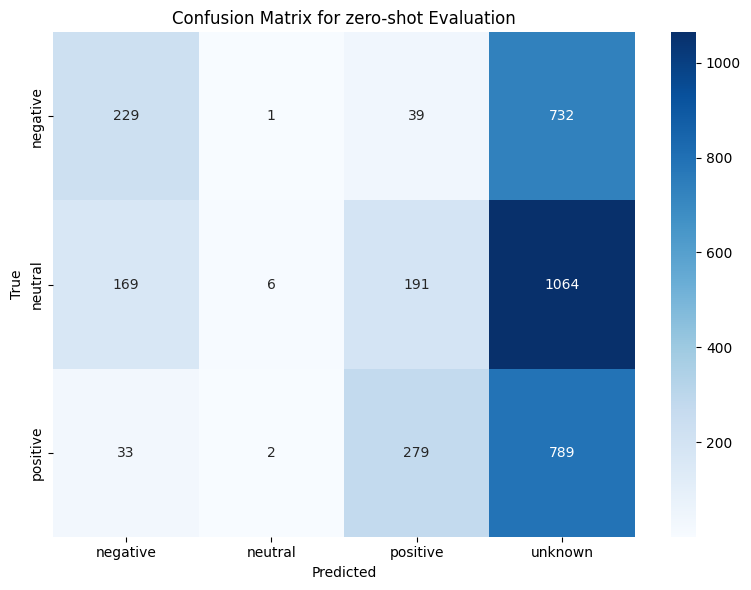

📝 Prediction Counts


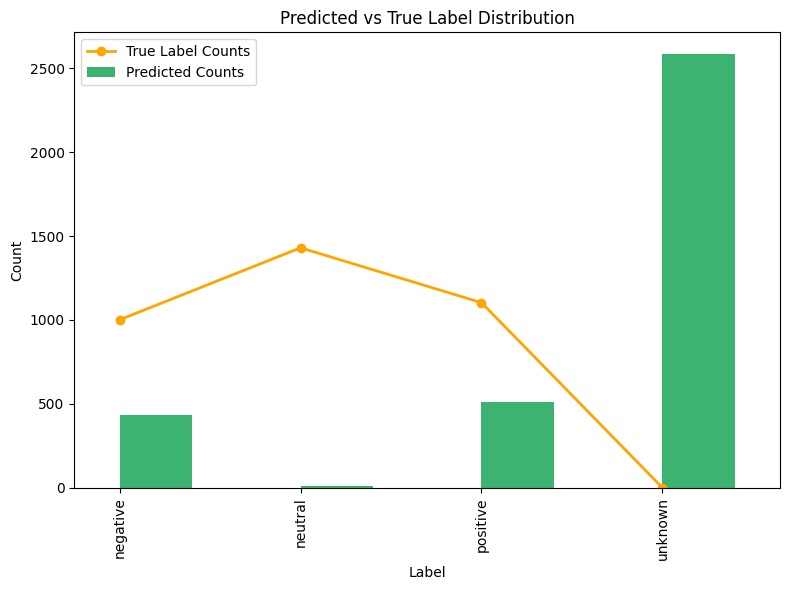

🧹 Cleared GPU cache and collected garbage.


In [26]:
evaluate_base_model(base_tokenizer, base_model, dataset['test'], eval_type='zero-shot')

## One-Shot Prompting

✅ one-shot prompts generated.


🔄 Processing batches: 100%|██████████| 8/8 [01:32<00:00, 11.58s/it]


✅ Completed all batches. Now calculating metrics...
✅ Completed all batches. Now calculating metrics...
📝 Accuracy: 0.54
📝 F1 score calculated: 0.47
📝 Classification report:
              precision    recall  f1-score   support

    negative       0.46      0.94      0.62      1001
     neutral       0.62      0.11      0.18      1430
    positive       0.65      0.74      0.69      1103
     unknown       0.00      0.00      0.00         0

    accuracy                           0.54      3534
   macro avg       0.43      0.45      0.37      3534
weighted avg       0.58      0.54      0.47      3534

📝 Confusion matrix:


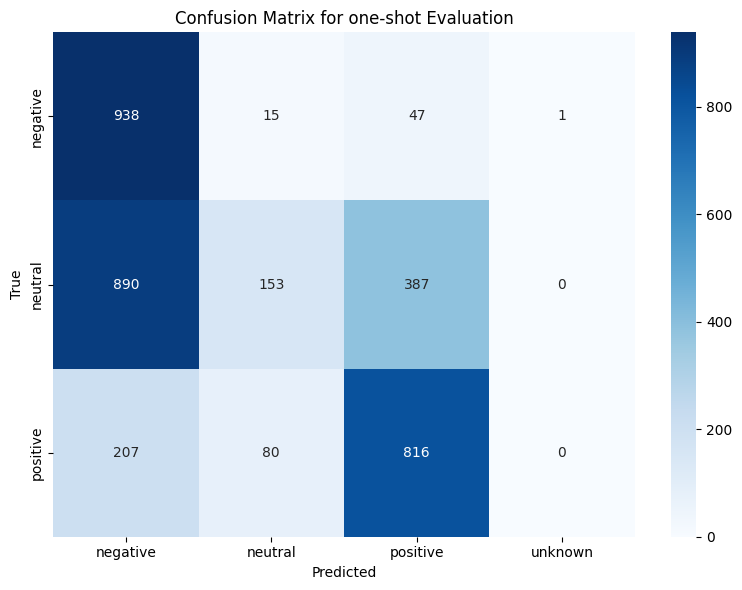

📝 Prediction Counts


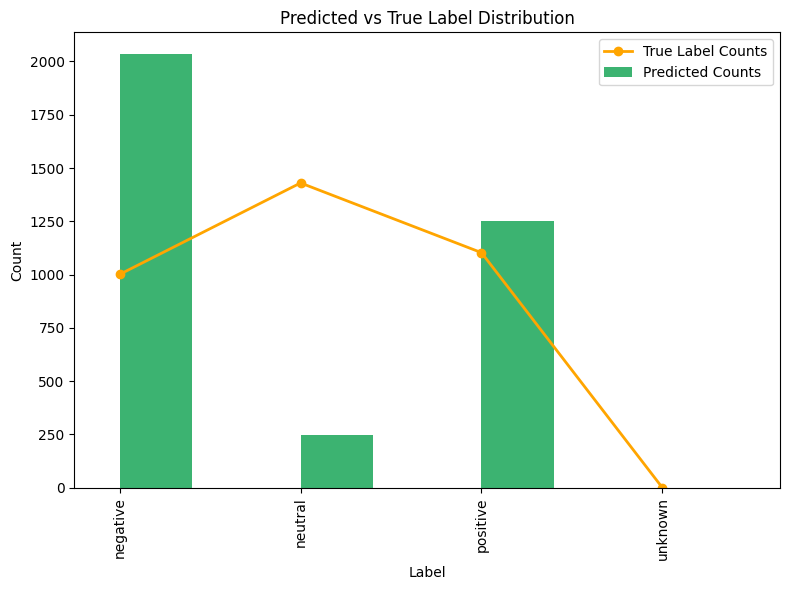

🧹 Cleared GPU cache and collected garbage.


In [27]:
evaluate_base_model(base_tokenizer, base_model, dataset['test'], eval_type='one-shot')

## Few-Shot Prompting

✅ few-shot prompts generated.


🔄 Processing batches: 100%|██████████| 8/8 [02:09<00:00, 16.13s/it]


✅ Completed all batches. Now calculating metrics...
✅ Completed all batches. Now calculating metrics...
📝 Accuracy: 0.57
📝 F1 score calculated: 0.51
📝 Classification report:
              precision    recall  f1-score   support

    negative       0.54      0.85      0.66      1001
     neutral       0.64      0.17      0.27      1430
    positive       0.59      0.84      0.69      1103

    accuracy                           0.57      3534
   macro avg       0.59      0.62      0.54      3534
weighted avg       0.60      0.57      0.51      3534

📝 Confusion matrix:


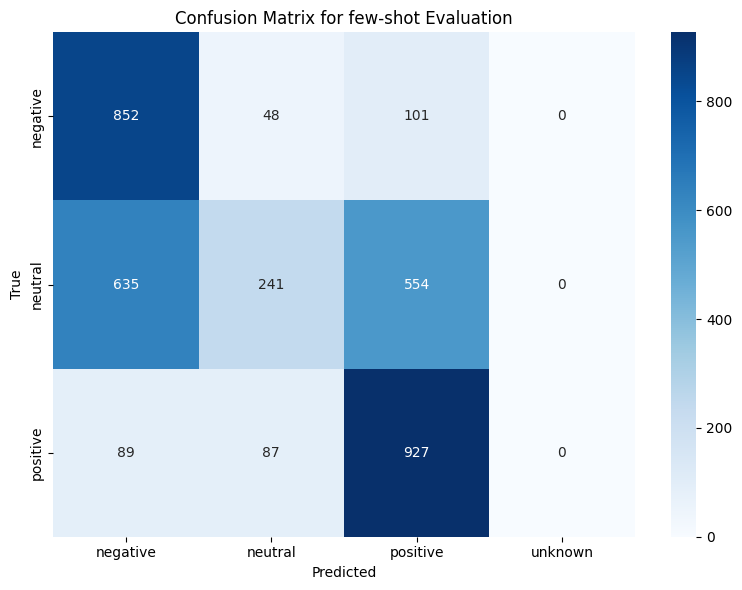

📝 Prediction Counts


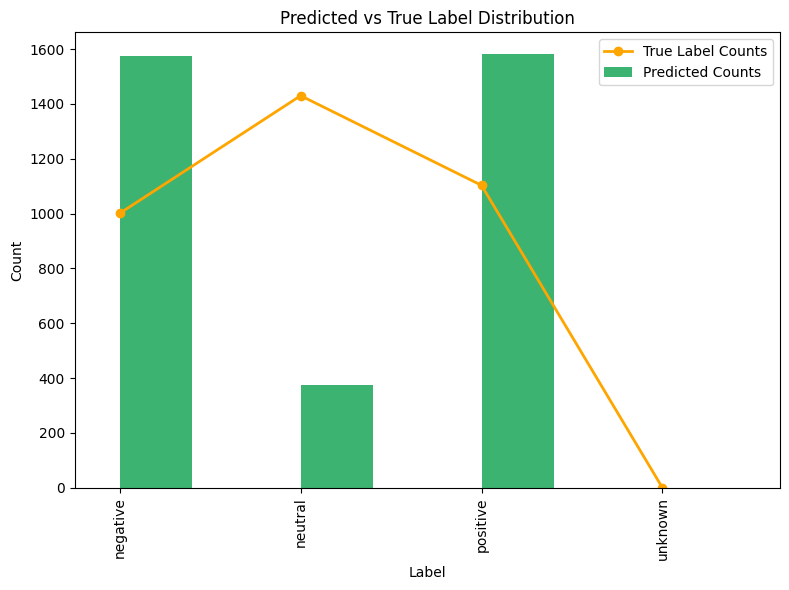

🧹 Cleared GPU cache and collected garbage.


In [28]:
evaluate_base_model(base_tokenizer, base_model, dataset['test'], eval_type='few-shot')

# Fine Tuned Evaluation

## Tweet only

✅ None prompts generated.


🔄 Processing batches: 100%|██████████| 8/8 [00:39<00:00,  4.99s/it]


✅ Completed all batches. Now calculating metrics...
✅ Completed all batches. Now calculating metrics...
📝 Accuracy: 0.73
📝 F1 score calculated: 0.73
📝 Classification report:
              precision    recall  f1-score   support

    negative       0.78      0.68      0.72      1001
     neutral       0.65      0.79      0.71      1430
    positive       0.83      0.69      0.76      1103

    accuracy                           0.73      3534
   macro avg       0.75      0.72      0.73      3534
weighted avg       0.74      0.73      0.73      3534

📝 Confusion matrix:


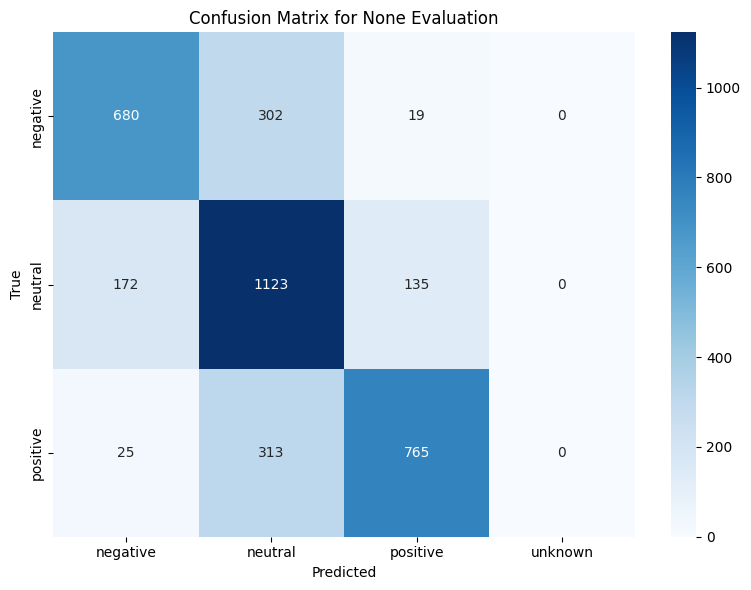

📝 Prediction Counts


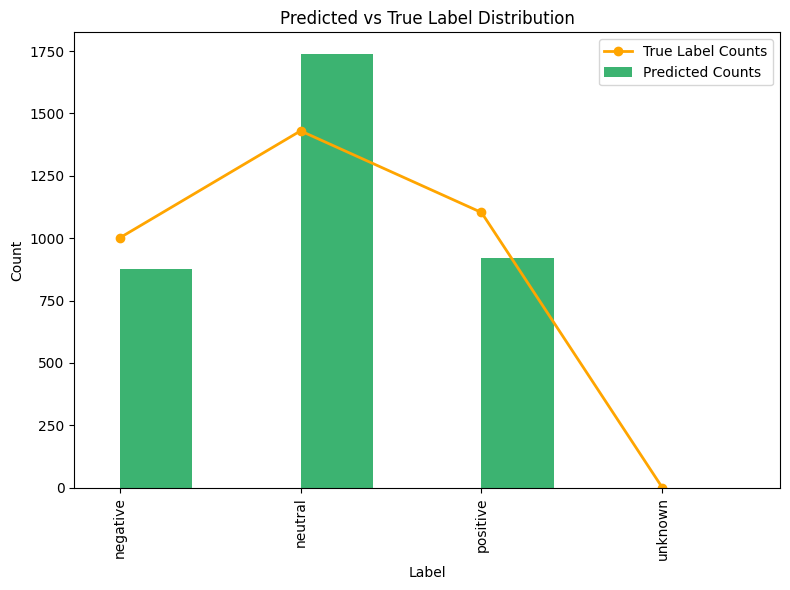

🧹 Cleared GPU cache and collected garbage.


In [29]:
evaluate_ft_model(ft_tokenizer, ft_model, dataset['test'], eval_type=None , batch_size=500)

## Zero-Shot Prompting

✅ zero-shot prompts generated.


🔄 Processing batches: 100%|██████████| 8/8 [00:52<00:00,  6.62s/it]


✅ Completed all batches. Now calculating metrics...
✅ Completed all batches. Now calculating metrics...
📝 Accuracy: 0.68
📝 F1 score calculated: 0.67
📝 Classification report:
              precision    recall  f1-score   support

    negative       0.78      0.56      0.65      1001
     neutral       0.57      0.85      0.68      1430
    positive       0.87      0.56      0.68      1103

    accuracy                           0.68      3534
   macro avg       0.74      0.66      0.67      3534
weighted avg       0.73      0.68      0.67      3534

📝 Confusion matrix:


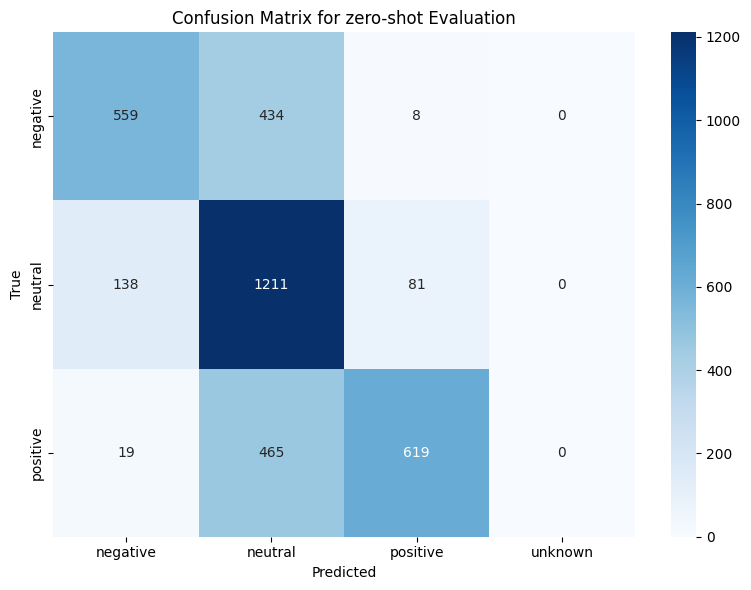

📝 Prediction Counts


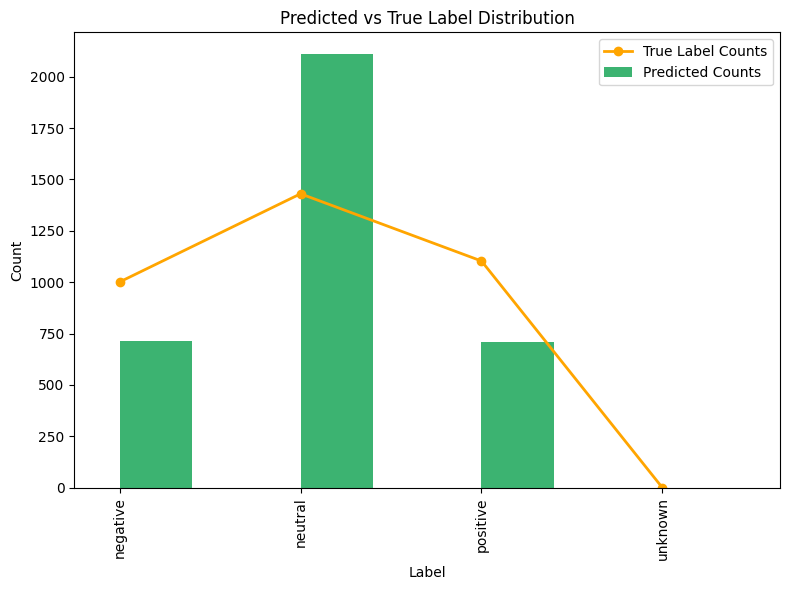

🧹 Cleared GPU cache and collected garbage.


In [30]:
evaluate_ft_model(ft_tokenizer, ft_model, dataset['test'], eval_type='zero-shot' , batch_size=500)

## One-Shot Prompting

✅ one-shot prompts generated.


🔄 Processing batches: 100%|██████████| 8/8 [01:13<00:00,  9.21s/it]


✅ Completed all batches. Now calculating metrics...
✅ Completed all batches. Now calculating metrics...
📝 Accuracy: 0.52
📝 F1 score calculated: 0.44
📝 Classification report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      1001
     neutral       0.46      0.89      0.60      1430
    positive       0.78      0.53      0.63      1103

    accuracy                           0.52      3534
   macro avg       0.41      0.47      0.41      3534
weighted avg       0.43      0.52      0.44      3534

📝 Confusion matrix:


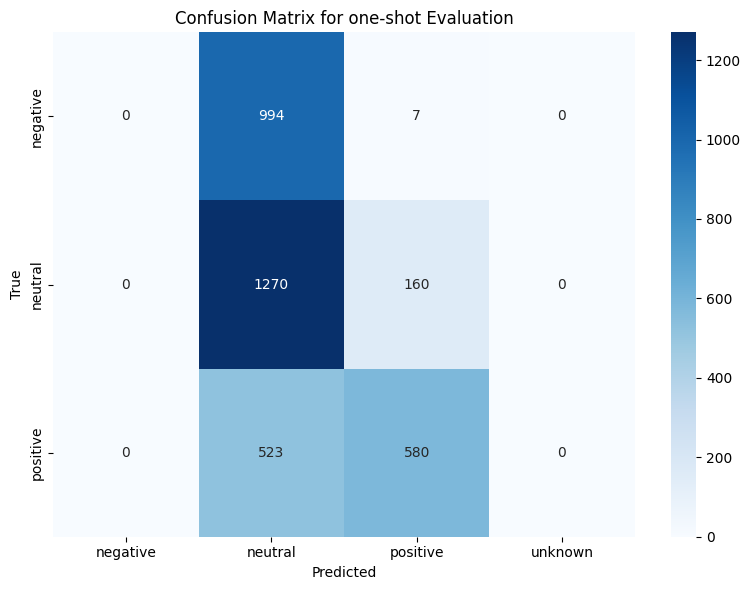

📝 Prediction Counts


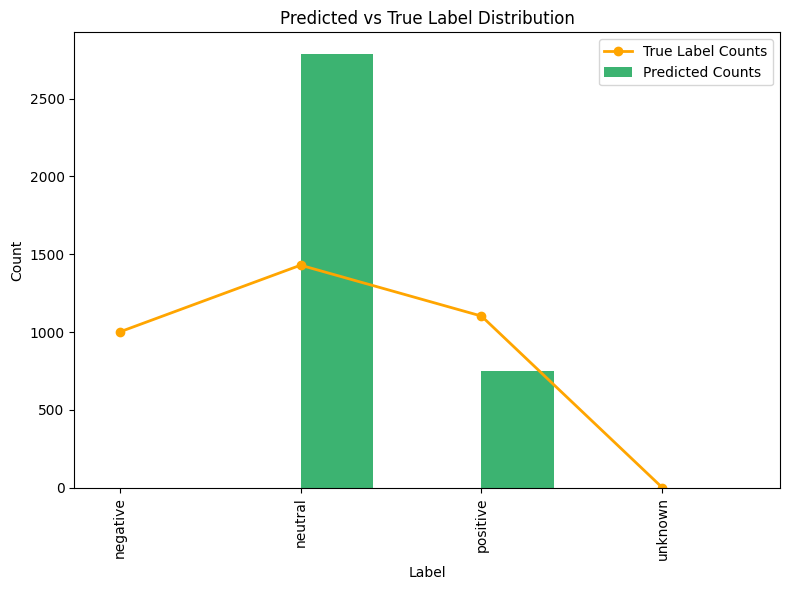

🧹 Cleared GPU cache and collected garbage.


In [31]:
evaluate_ft_model(ft_tokenizer, ft_model, dataset['test'], eval_type='one-shot' , batch_size=500)

## Few-Shot Prompting

✅ few-shot prompts generated.


🔄 Processing batches: 100%|██████████| 8/8 [01:46<00:00, 13.26s/it]


✅ Completed all batches. Now calculating metrics...
✅ Completed all batches. Now calculating metrics...
📝 Accuracy: 0.43
📝 F1 score calculated: 0.28
📝 Classification report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      1001
     neutral       0.41      1.00      0.59      1430
    positive       0.93      0.08      0.15      1103

    accuracy                           0.43      3534
   macro avg       0.45      0.36      0.25      3534
weighted avg       0.46      0.43      0.28      3534

📝 Confusion matrix:


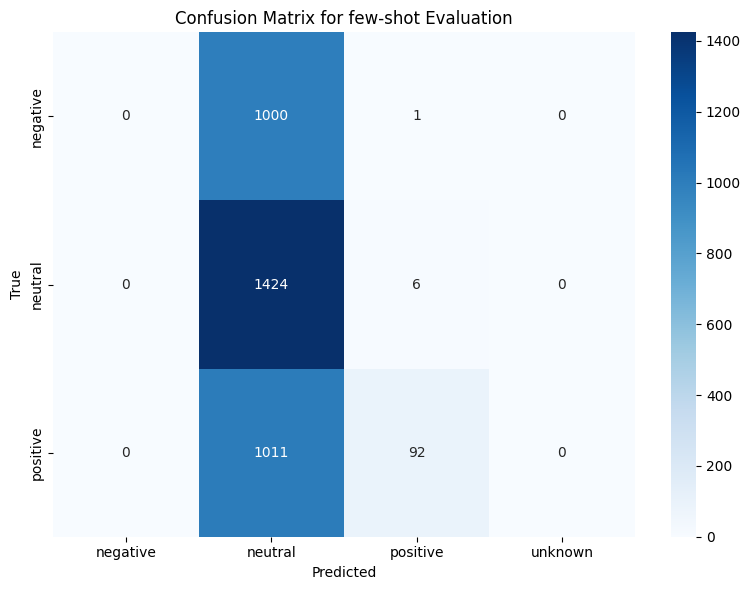

📝 Prediction Counts


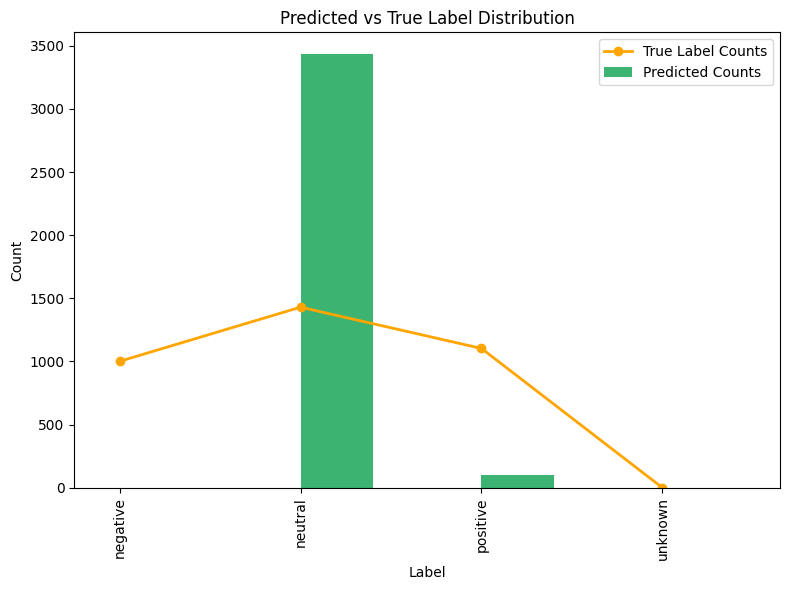

🧹 Cleared GPU cache and collected garbage.


In [32]:
evaluate_ft_model(ft_tokenizer, ft_model, dataset['test'], eval_type='few-shot' , batch_size=500)

# GC

In [42]:
# del inputs, outputs  # GPU tensors
# del cleaned_responses, predictions, responses  # CPU side, optional
torch.cuda.empty_cache()
gc.collect()


177